In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import sys
import os
sys.path.append(os.path.abspath(os.path.join('../../functions/')))

import prep_functions

fetcher = prep_functions.ExchangeRateFetcher('KRW')

In [19]:
origin_india_df = pd.read_csv('../../data/amazon.csv')
india_df = pd.read_csv('../../data/amazon_india.csv')
canada_df = pd.read_csv('../../data/amazon_canada.csv')
uk_df = pd.read_csv('../../data/amazon_uk.csv')
usa_df = pd.read_csv('../../data/amazon_usa.csv')

In [20]:
# price 관련 컬럼 수정
price_cols = ['discounted_price', 'actual_price']
origin_india_df[price_cols] = origin_india_df[price_cols].replace({'₹': '', ',': ''}, regex=True).astype(float)
origin_india_df['discount_percentage'] = origin_india_df['discount_percentage'].replace('%', '', regex=True).astype(float)

In [21]:
# rating 관련 컬럼 수정
origin_india_df = origin_india_df[origin_india_df['rating_count'].notnull()]
origin_india_df = origin_india_df.reset_index().drop(columns=('index'))
origin_india_df.loc[origin_india_df['rating'].str.contains('|', regex=False), 'rating'] = 3.8

In [22]:
def drop_price(df):
    df.drop(columns=['discounted_price','actual_price'], inplace=True)
    
drop_price(india_df)
drop_price(canada_df)
drop_price(usa_df)
uk_df.drop(columns=['discounted_price'], inplace=True)

In [23]:
# price 통화 변경
def convert_currency(row, col):
    if row[col] == 0:
        return 0
    return fetcher.convert(row[col], 'INR', 'KRW')

origin_india_df['discounted_price_KRW'] = origin_india_df.apply(lambda row: convert_currency(row, 'discounted_price'), axis=1).astype(int)
origin_india_df['actual_price_KRW'] = origin_india_df.apply(lambda row: convert_currency(row, 'actual_price'), axis=1).astype(int)

In [24]:
origin_india_df['rating'] = origin_india_df['rating'].astype(float)
origin_india_df['rating_count'] = origin_india_df['rating_count'].str.replace(',','').astype(int)
origin_india_df = origin_india_df.drop_duplicates(subset=['product_id', 'product_name', 'discounted_price_KRW', 'actual_price_KRW'], keep='last')

In [25]:
# 카테고리 추가
origin_india_df.loc[:, 'big_category'] = origin_india_df['category'].apply(lambda x: x.split('|')[0])
origin_india_df.loc[:, 'small_category'] = origin_india_df['category'].apply(lambda x: x.split('|')[-2])

---

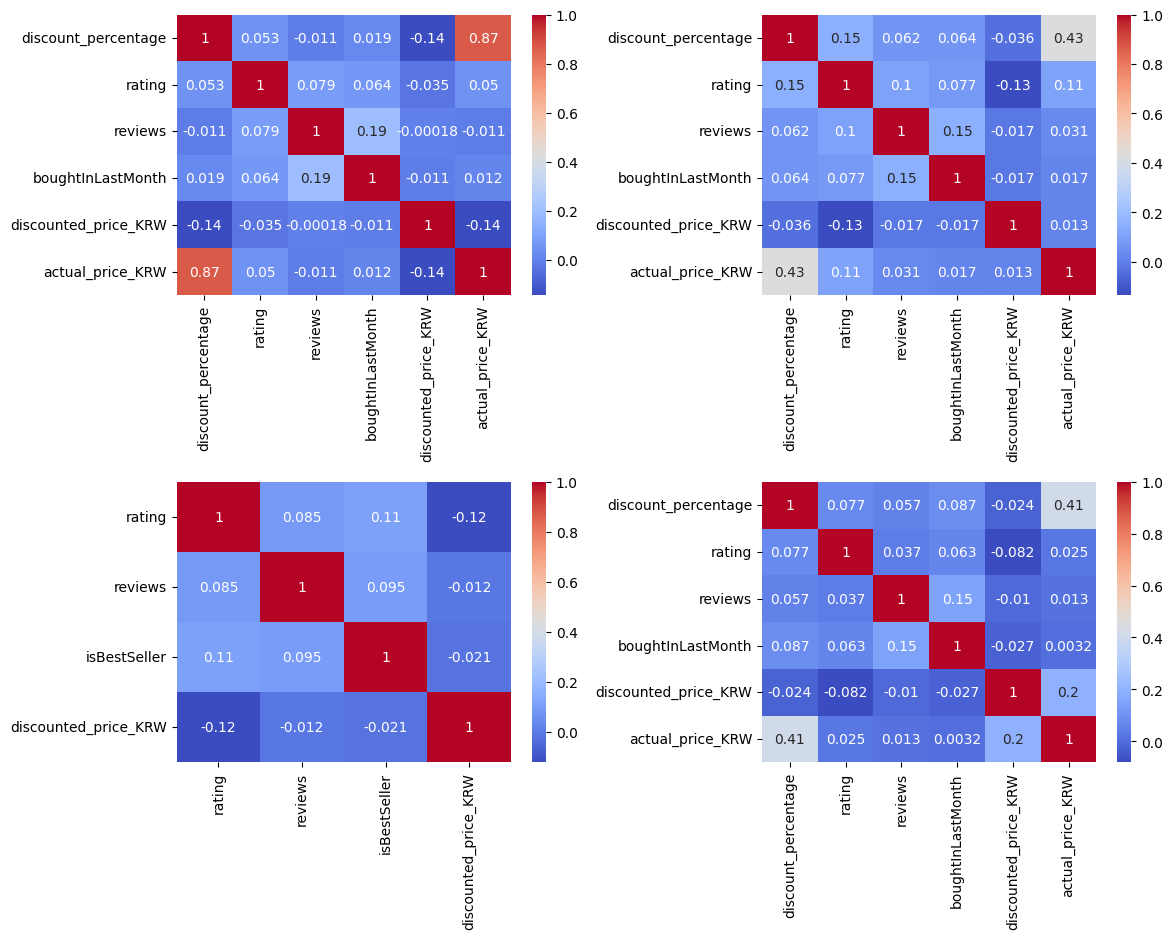

In [26]:
# 상관계수
def numeric(dfs):
    num_dfs = [df.select_dtypes(include=['number']) for df in dfs]
    return check_corr(num_dfs)

def check_corr(dfs):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for ax, df in zip(axes.flat, dfs):
        corr = df.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

numeric([india_df, canada_df, uk_df, usa_df])

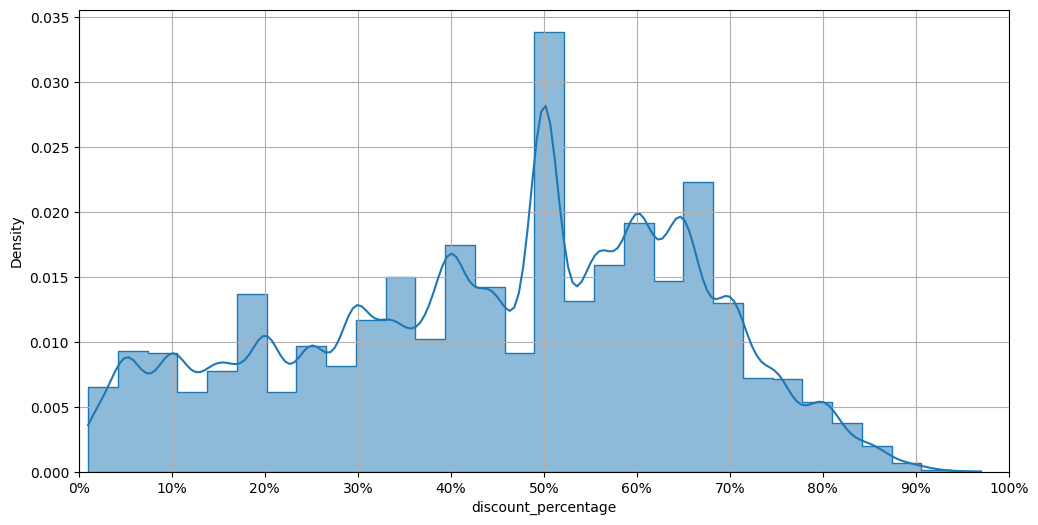

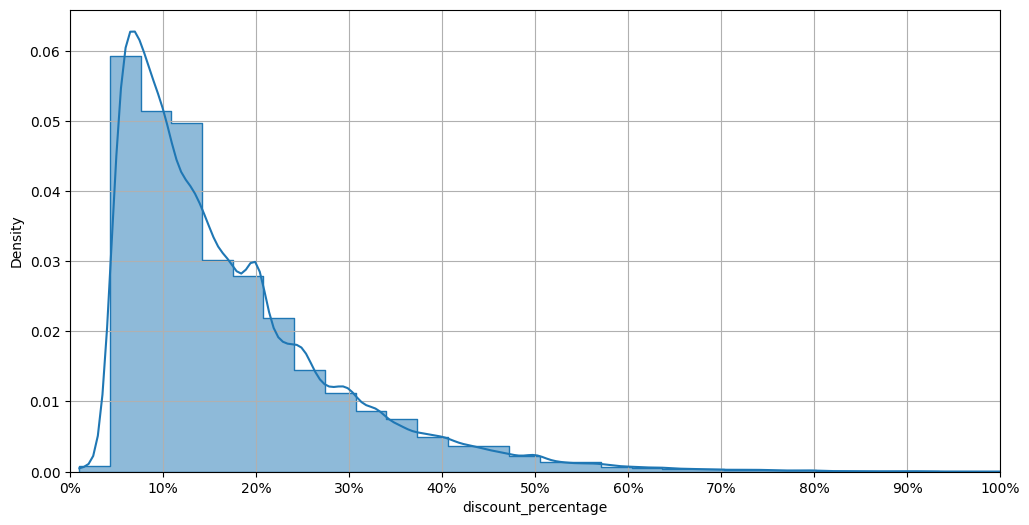

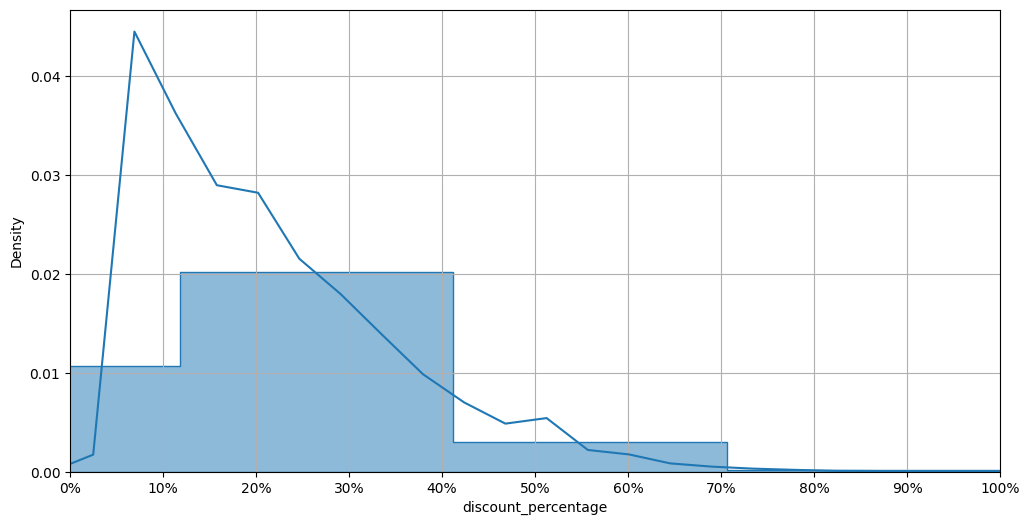

In [27]:
# 할인율 0인 데이터 제외, 할인율 빈도
def filter_zero_pc(dfs):
    filtered = [df.query('discount_percentage != 0') for df in dfs]
    discounted_pc_histogram(filtered)
    
def discounted_pc_histogram(dfs):
    for df in dfs:
        plt.figure(figsize=(12, 6))
        sns.histplot(data=df, x='discount_percentage', bins=30, kde=True, stat='density', element='step')
        
        plt.xlim(0, 100)
        ticks = range(0, 101, 10)
        plt.xticks(ticks, [f'{tick}%' for tick in ticks])
        plt.grid()
        plt.show()
        
filter_zero_pc([india_df, canada_df, usa_df])

----

In [35]:
def elbow_graph(df, cols, x, y):
    # df = df.query(f'{x} != 0 and {y} != 0')
    df = df[cols]
    
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    inertia = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
        kmeans.fit(df_scaled)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(8, 4))
    plt.plot(K, inertia, 'bx-')
    plt.show()


def Kmeans(dataframe, cols, x='PCA1', y='PCA2', cluster=4):
    df = dataframe.copy()
    # df = df.query(f'{x} != 0 and {y} != 0')
    # df = df.query(f'discount_percentage != 0')
    cluster_df = df[cols]

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(cluster_df)

    kmeans = KMeans(n_clusters=cluster, n_init=10, random_state=42)
    plt.figure(figsize=(10, 8))

    if len(cols) > 2:
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(df_scaled)
        pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
        pca_df['cluster'] = kmeans.fit_predict(df_scaled)
        sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='viridis', alpha=0.7)
        plt.xlabel('PCA1')
        plt.ylabel('PCA2')
    else:
        df_copy = df.copy()
        df_copy['cluster'] = kmeans.fit_predict(df_scaled)
        sns.scatterplot(data=df_copy, x=x, y=y, hue='cluster', palette='viridis', alpha=0.7)
        plt.xlabel(x)
        plt.ylabel(y)
    # plt.xlim(0, 1.0 * 1e6)  # 0.0 ~ 0.2 (단위: 1e6)
    # plt.ylim(0, 1.5 * 1e6)  # 0.0 ~ 0.5 (단위: 1e6)
    plt.title(f'K-Means Clustering with {cluster} Clusters')
    plt.grid()
    plt.show()

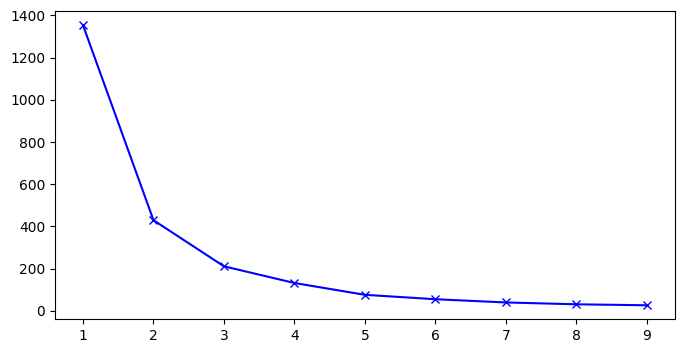

In [29]:
elbow_graph(india_df, ['discount_percentage','rating', 'reviews'])

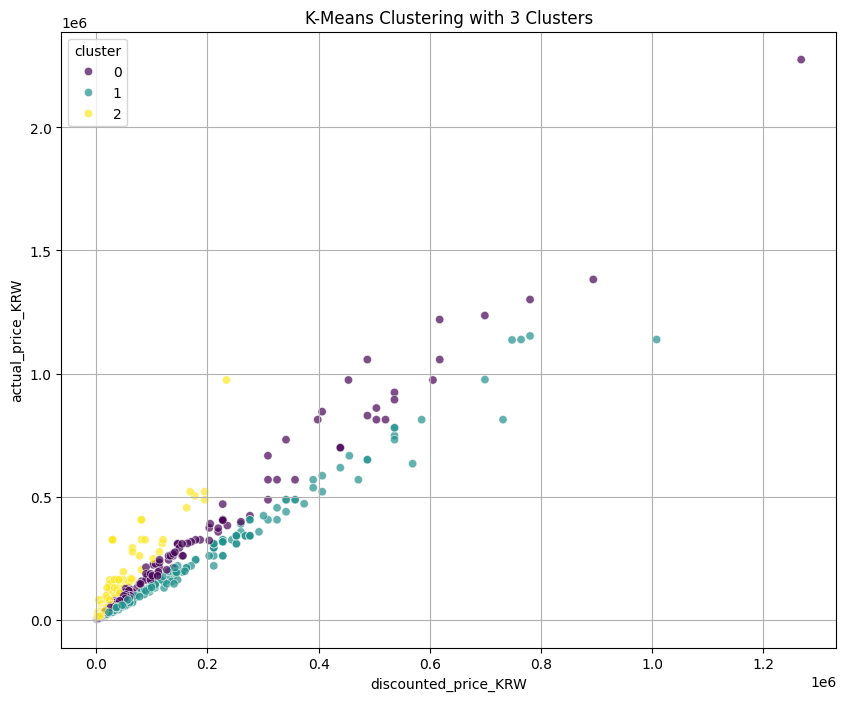

In [30]:
Kmeans(origin_india_df, ['discount_percentage'], 'discounted_price_KRW', 'actual_price_KRW')

In [31]:
india_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497145 entries, 0 to 1497144
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   product_id            1497145 non-null  object 
 1   product_name          1497145 non-null  object 
 2   category              1497145 non-null  object 
 3   discount_percentage   1497145 non-null  int64  
 4   rating                1497145 non-null  float64
 5   reviews               1497145 non-null  int64  
 6   img_link              1497145 non-null  object 
 7   product_link          1497145 non-null  object 
 8   isBestSeller          1497145 non-null  bool   
 9   boughtInLastMonth     1497145 non-null  int64  
 10  discounted_price_KRW  1497145 non-null  int64  
 11  actual_price_KRW      1497145 non-null  int64  
dtypes: bool(1), float64(1), int64(5), object(5)
memory usage: 127.1+ MB


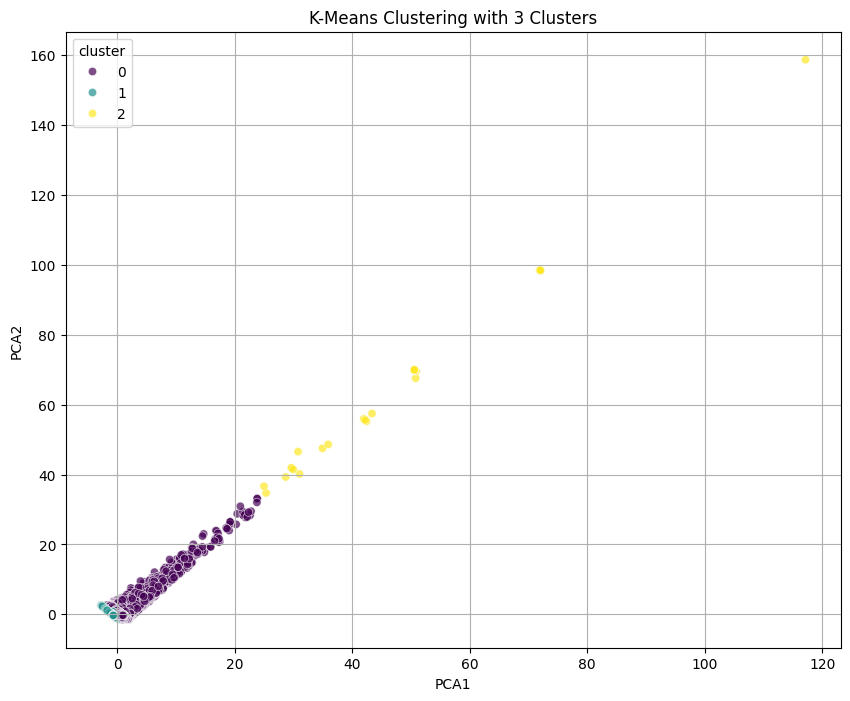

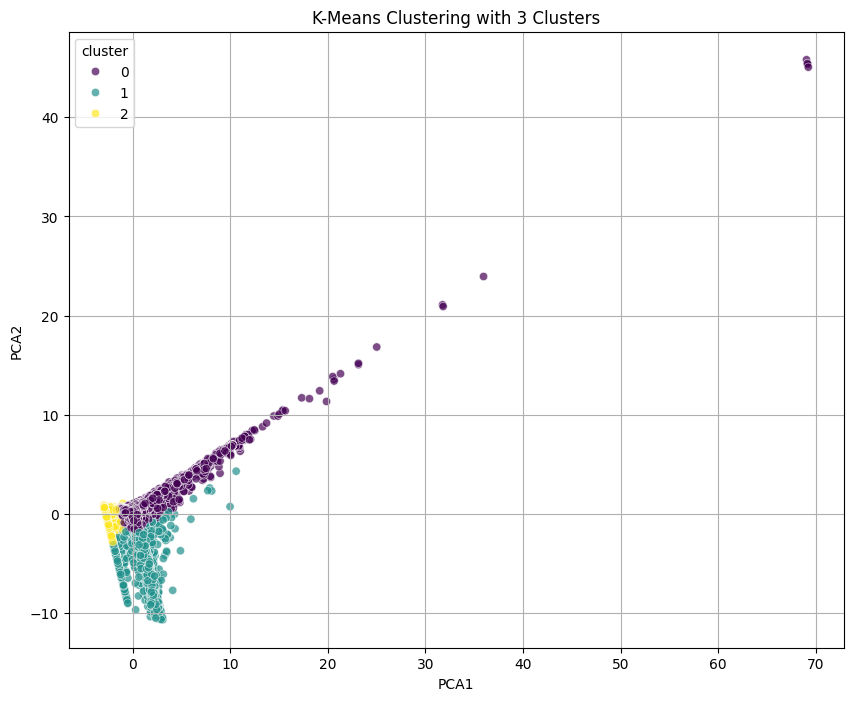

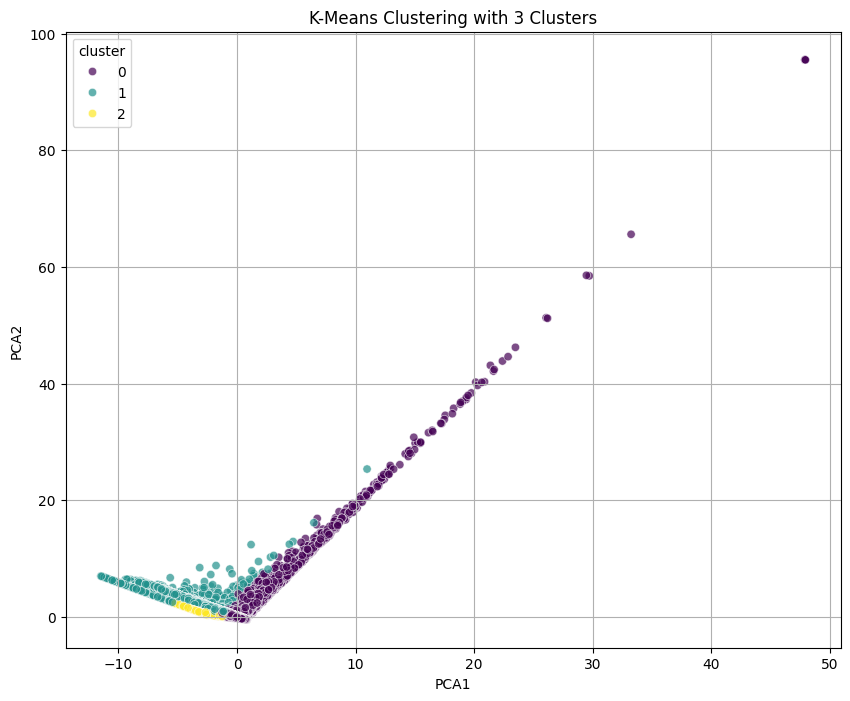

In [34]:
country = [india_df, canada_df, usa_df]

for c in country:
    # c = c.copy()
    # elbow_graph(c, ['discount_percentage'], 'discounted_price_KRW', 'actual_price_KRW')
    # Kmeans(c, ['discount_percentage','rating', 'reviews'])
    Kmeans(c, ['discounted_price_KRW','rating', 'reviews'])